# Текущий план
- Посчитать теги с учетом тега "VERSION"
- Сделать вывод всех необходимых строк для использования в HTML

# Описание задачи

**Цель**: сделать веб-приложение, помогающее авторам и редакторам IT-публикаций подбирать к ним удачные заголовки.

**Задача-минимум**: создать сервис, который учит пользователя (автора, редактора) использовать разумные подходы для составления говорящего заголовка. По такому заголовку читатель понимает, какую пользу он получит от прочтения статьи.

**Идея MVP**. Проблему можно сформулировать в виде задачи распознавания именованных сущностей (англ. [Named Entity Recognition](https://en.wikipedia.org/wiki/Named-entity_recognition), NER). Распознанные именованные сущности можно далее вмесе с токенизированным текстом использовать для выставления условного балла от 0 до 10, позволяющего автору быстро оценить результат.

**Задача-минимум**: веб-страница, на которой пользователь вводит строку заголовка, а в ответ получает:
1) оценка заголовка,
2) найденные полезные индикаторы
3) подсказки, что далее делать с заголовком.

**Задача-максимум** (пока не решаем): генерация вариантов более качественных заголовков по тексту публикации или сочетанию чернового заголовка и краткого содержания.


# Инструментарий
- Python 3
- NLP-библиотека [spaCy 3.0](https://spacy.io/). Мы выбрали `spacy` так как это стабильная библиотека, ориентированная на конечное использование в коммерческих приложениях. Однако 3-я версия не очень хорошо зарекомендовала для себя для классификации большого набора данных, а transformers оказалась слишком долгой для обучения и медленной для задачи веб-сервиса. Поэтому мы использовали быстрый CatBoost.
- ML-библиотека CatBoost (использовалась для оценки возможности построения ML-модели, на деле не применяется).

Для разметки эталонного набора именованных сущностей использовалось [Label Studio](https://labelstud.io/). Вручную было размечено 3000 заголовков, далее эти результаты использовались для полуавтоматической разметки. Для разметки данных мы использовали стандартный формат [CoNLL format](https://www.signll.org/conll/) ([StackOverflow discussion](https://stackoverflow.com/questions/27416164/what-is-conll-data-format)).

In [3]:
from subprocess import PIPE, run
from itertools import combinations
import json

# библиотеки обработки данных
import numpy as np
import pandas as pd
from scipy import stats

# прогрессбар
from tqdm.auto import tqdm
tqdm.pandas()

# natural language processing
import spacy
from spacy import displacy

# ml models
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, minmax_scale, quantile_transform
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE

from catboost import Pool, CatBoostRegressor

# визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# фильтрация некритичных предупреждений pandas b jupyter
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore",
                      category=SettingWithCopyWarning)

DATASETS_PATH = '../../DATASETS/title'

%matplotlib inline

# 1. Подготовка текстового корпуса

## 1.1. Изучим датасет, содержащий заголовки и число просмотров

С помощью веб-парсинга мы собрали большое количество данных в один общий датасет. 

In [3]:
def read_df():
    df = pd.read_feather(f'{DATASETS_PATH}/total.feather')    
    df = df.set_index('url')  # feather doesn't work with str indices
    
    # parse timing cols ad datetime
    for col in ('post_time', 'parse_time'):
        df[col] = pd.to_datetime(df[col])
    
    return df

df = read_df()
df.head()

,title,summary,views_num,post_time,parse_time,likes_num,favs_num,comments_num,source,fulltext_saved
url,,,,,,,,,,
https://tproger.ru/articles/7-prakticheskih-zadanij-s-sobesedovanija-na-poziciju-junior-java-developer/,7 практических заданий с собеседования на пози...,Для начинающего разработчика очень важно не то...,8642,2021-03-01 09:05:11,2021-04-19,13,10,10,tproger,True
https://tproger.ru/quiz/test-chto-mozhet-jeta-nejroset/,"Тест: что реально, а что создала нейросеть?",Сегодня нейронные сети используются в сельском...,4967,2021-02-26 19:39:50,2021-04-19,2,1,0,tproger,True
https://tproger.ru/articles/kak-najti-dejstvitelno-horoshij-kurs-po-razrabotke-8-shagov-na-puti-k-pravilnomu-vyboru/,Как найти действительно хороший курс по разраб...,Сразу хочется пошутить и предложить разработат...,1291,2021-02-26 17:29:00,2021-04-19,1,4,1,tproger,True
https://tproger.ru/articles/blackbox-skanery-v-processe-ocenki-bezopasnosti-prilozhenija/,Blackbox-сканеры в процессе оценки безопасност...,Профиль задач quality engineer (QE) достаточно...,233,2021-02-26 15:16:46,2021-04-19,0,1,0,tproger,True
https://tproger.ru/articles/instrumenty-upravlenija-komandoj-razrabotki-na-udalenke-kak-ne-meshat-rabotat/,Инструменты управления командой разработки на ...,В КРОК геораспределенная структура офисов разр...,589,2021-02-25 18:56:54,2021-04-19,3,3,0,tproger,True


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 323265 entries, https://tproger.ru/articles/7-prakticheskih-zadanij-s-sobesedovanija-na-poziciju-junior-java-developer/ to https://dev.by/news/besarab-chto-chitat
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   title           323265 non-null  object        
 1   summary         322943 non-null  object        
 2   views_num       308037 non-null  Int32         
 3   post_time       322643 non-null  datetime64[ns]
 4   parse_time      322756 non-null  datetime64[ns]
 5   likes_num       217990 non-null  Int16         
 6   favs_num        217990 non-null  Int16         
 7   comments_num    316750 non-null  Int16         
 8   source          323265 non-null  object        
 9   fulltext_saved  323265 non-null  bool          
dtypes: Int16(3), Int32(1), bool(1), datetime64[ns](2), object(3)
memory usage: 19.4+ MB


Посмотрим на распределение статей по источникам:

In [5]:
df.source.value_counts()

habr            214949
vc               46635
xakep            36752
devby            14717
dou               5680
proglib           1750
tproger           1293
tinkoff            656
thecode            509
digitalocean       324
Name: source, dtype: int64

## 1.2. ML-коррекция заниженного количества просмотров

Количество просмотров на сайтах иногда значительно отстает от ожидаемого или не всегда рассчитывается правильно.

Например, для новых статей или статей, изменивших статус публичности. Особенно это заметно, когда количество просмотров меньше количества лайков и закладок. Чтобы исправить такие значения, построим простую регрессионную модель на данных, которым мы можем доверять. Далее экстраполируем результат на «подозрительные» данные.

In [6]:
df['timedelta'] = (df.parse_time - df.post_time).apply(lambda x: x.total_seconds())*1e-6
df_tmp = df[['likes_num', 'favs_num', 'comments_num', 'views_num', 'source', 'timedelta']].dropna()

# for categorical data (source feature)
df_tmp = pd.get_dummies(df_tmp)
df_tmp['suspicious'] = [False]*df_tmp.shape[0]
for col in ('likes', 'favs', 'comments'):
    df_tmp['suspicious'] += df_tmp[f'{col}_num'] > 0.1*df_tmp['views_num']

df_tmp_susp = df_tmp[df_tmp['suspicious'] == True]
df_tmp = df_tmp[df_tmp['suspicious'] == False]

df_tmp = df_tmp.drop(columns=['suspicious'])
df_tmp_susp = df_tmp_susp.drop(columns=['suspicious'])

y = df_tmp['views_num']
X = df_tmp.drop(columns=['views_num'])
reg = make_pipeline(StandardScaler(),
                    RandomForestRegressor(n_jobs=20))
reg.fit(X, y)
df_tmp_susp['views_num'] = reg.predict(df_tmp_susp.drop(columns=['views_num']))
df_tmp_susp['views_num'] = df_tmp_susp['views_num'].apply(round)
df_tmp = pd.concat([df_tmp, df_tmp_susp])

df.update(df_tmp)

Теперь мы можем исключить данные, которые не содержат числа просмотров:

In [7]:
df = df.dropna(subset=['views_num'])

Далее мы не будем учитывать сайт, на котором размещена публикация, поэтому нормируем число просмотров для статей определенного источника на максимальное для каждого из них.

In [8]:
for s in df.source.unique():
    cond = (df.source == s)
    m = df.loc[cond].views_num.max()
    df.loc[cond, 'views_num'] /= m

## 1.3. Отбор признаков для работы

**Число просмотров** — наша целевая переменная.

**Время от публикации до парсинга**. Важной характеристикой публикации является то, когда она была опубликована. Тематики статей меняются, растет число людей с доступом в интернет. Со временем статьи с актуальными темами продолжают получать дочитывания, а наиболее новые статьи еще не набрали своего. В результате мы имеем следующее распределение просмотров относительно шкалы времени:

Text(0, 0.5, 'Число просмотров.')

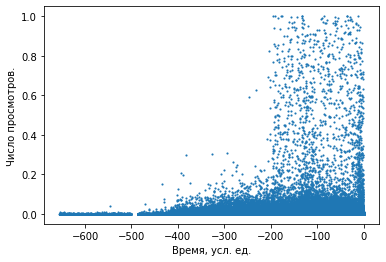

In [9]:
plt.scatter(-df.timedelta,
            df.views_num,
            s = 5,
            marker='.')
plt.xlabel('Время, усл. ед.')
plt.ylabel('Число просмотров.')

Для новых публикаций мы будем указывать нулевую отметку времени.

В результате мы используем сами тексты заголовков, число просмотров и интервал времени, за который число просмотров было набрано:

In [14]:
Xy = df[['timedelta', 'title', 'views_num']].reset_index(drop=True)
Xy.views_num = Xy.views_num.fillna(0)

## 1.4. Предобработка числовых данных

С помощью z-оценки выкинем явные выбросы (оказалось, что это примерно 5 тыс. статей).

(306402, 3)


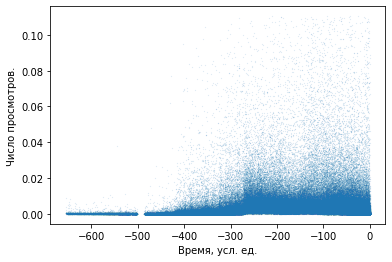

In [15]:
Xy['z_score'] = stats.zscore(Xy['views_num'])
Xy = Xy.loc[Xy['z_score'].abs()<=3]
Xy = Xy.drop(columns=['z_score'])
Xy.reset_index(drop=True, inplace=True)
print(Xy.shape)

plt.scatter(-Xy.timedelta,
            Xy.views_num,
            s = 0.01,
            marker='.')
plt.xlabel('Время, усл. ед.')
plt.ylabel('Число просмотров.')
plt.show()

Гистограмма распределния числа просмотров: 

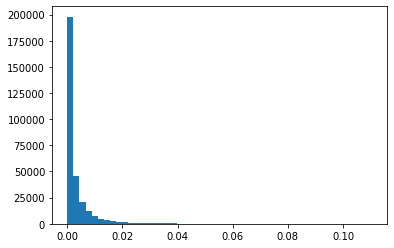

In [16]:
plt.hist(Xy.views_num, bins=50)
plt.show()

Кривая имеет предсказуемый характер, поэтому мы можем воспользоваться  преобразованием [Quantile Transform](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.quantile_transform.html#sklearn.preprocessing.quantile_transform), чтобы трансформировать распределение к нормальному виду.

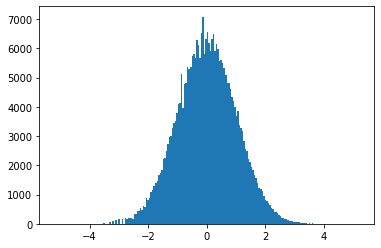

In [17]:
y = Xy.views_num.to_numpy().reshape(-1, 1)
Xy['y'] = quantile_transform(y, output_distribution='normal')
plt.hist(Xy['y'], bins=200)
plt.show()

Для переменной времени применим обычную нормировку по интервалу, чтобы данные лежали в диапазоне `[0, 1]`:

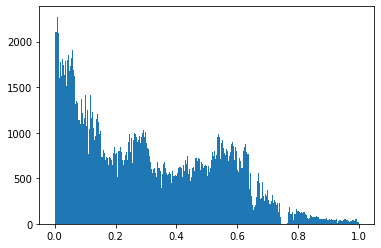

In [18]:
Xy.timedelta = minmax_scale(Xy.timedelta)
plt.hist(Xy.timedelta, bins=500)
plt.show()

# 2. Обучение модели распознавания именованных сущностей (модель NER)

В качестве базовой модели `spacy` мы используем `ru_core_news_lg`. В ней уже имеются сущности `PER` (персоналий), организаций (`ORG`), географических локаций (`LOC`). Кроме имеющихся именованных сущностей мы добавили в разметку следующие категории и подкатегории:

1. **Объект** `OBJ`. *О чём* эта статья.  Если заголовок состоит только из таких сущностей, значит перед нами что-то вроде статьи из словаря — объяснение сущности самого объекта. Примеры: "LESS: программируемый язык стилей", "Composer — менеджер зависимостей для PHP".
2. **Аудитория** `AUD`. Для кого написан этот текст. Примеры индикаторов аудитории: "для новичков, на Windows, профи, любой аккаунт, до 30 лет, русская версия" Аудитория выражается и просто через "я" — мы сравниваем себя с другими людьми через наш общий или различный опыт. Наиболее читаемые статьи обращаются к аудитории новичков, но это не значит, что их читают только новички. "Пайка для начинающих", "Hello World-проект на Flask", "Основы IP-телефонии", "Какой язык программирования стоит выучить пер
вым?".
3. **Польза**. Какую проблему показывает или решает публикация. В чём ее профит?
Польза может выражаться самыми разными способами:
      + **Маркеры типа текста** `TYPE`: инструкция ("как установить", "Шаблон базовой настройки маршрутизатора Cisco"), определение ("что такое... и с чем едят"), новость (Новое в Java 8"), личный опыт, сравнение объектов ("X или Y", "Python vs R") и т. д. По маркеру типа текста мы понимаем, с чем имеем дело.
     + **Указание числа используемых источников или рассматриваемых объектов** `NUM`: "10 лучших", "ТОП-3".
     + **Усилия и время, которые потратит читатель на саму статью или процесс** `EFFORT`: "За 15 минут, за один вечер, за один год, краткое руководство, в 11 строчек кода". Вполне возможно, что у человека достаточно времени, и он хочет детально во всём разобраться: "Подробно о..., всё про...". Главное, что вся нужная информация нашлась в одном месте.
    + **Маркеры последовательного подхода, нового типа изложения** `STRUCT`. В интернете не хватает структурированной информации, люди любят когда рассказывают "по порядку, детально, без воды".
    + **Предостережение об опасности или возможной ошибке** `DANGER`: "Проблема в ... и ее их решение", "Взлом... от которого не спасёт", " "X – ловушка для неопытных. Осторожно".
    + **Маркировка акта длинного повествования** `PART`. Указание части в заголовке подсказывает: перед нами часть большого текста. Хорошо работает следующий формат: "Общее название группы технологий. Часть N. Название технологии."  Примеры: "jQuery для начинающих. Часть 3. AJAX". "Bash-скрипты, часть 2: циклы". "Пишем игры на C++, Часть 1/3 — Написание мини-фреймворка", "Сети для самых маленьких. Часть шестая. Динамическая маршрутизация".
    + **Преимущество получаемое читателем**: бесплатно, своими руками, в домашних условиях
4. **Источник движения** — в хороших статьях заложена история путешествия, они приводят читателя из пункта А в пункт Б. Саму историю расскажет статья, но полезно прочертить вектор с помощью глагола, или если придется к месту — искренней эмоции.
    + **Побуждение к действию или само действие** `TODO`. Что мы будем делать в этой статье. "Пишем программу...", "настройка, обзор, запуск, ремонт". Примеры: "Извлекаем золото из старой электроники", "Запуск старых игр на Windows".
    + **Эмоция** `EMO`. С эмоциями не стоит перебарщивать, но иногда сильная эмоция или выражение отношения — то, что нужно. "Xудшее, что могло с нами случиться." "Почему научиться программировать так чертовски тяжело?". Помните: читатель не дурак, эмоции в заголовке работают только, если они неподдельные.

Однако нужно помнить, что каким бы ни был заголовок, главное – сам текст и внимательное отношение к читателю.

In [19]:
def out(command):
    '''Выводит данные '''
    result = run(command, stdout=PIPE,
                 stderr=PIPE, universal_newlines=True,
                 shell=True)
    return result.stdout


try:
    nlp = spacy.load("./nlp_model/model-best")
except OSError:
    # если модель ещё не обучалась
    # используем в качестве старта предобученную
    import ru_core_news_lg
    nlp = ru_core_news_lg.load()
    print(out("spacy init fill-config ./nlp_model/base_config.cfg ./nlp_model/config.cfg"))
    print(out("spacy convert .nlp_model/train_data/title_ner.conll ./nlp_model/train_data/"))
    # это всего лишь прямой вызов из командной строки
    !spacy train config.cfg --output ./nlp_model --paths.train ./nlp_model/train_data/title_ner.spacy --paths.dev ./nlp_model/train_data/title_ner.spacy

На нескольких примерах проверим корректность поиска именованных сущностей:

In [182]:
# в файле tags.json хранятся данные 
with open(f'nlp_model/tags.json') as f:
    tags = json.load(f)

# определим, какие сущности мы зарезервировали
tag_names = list(tags.keys())

examples = ['ТОП-3 книги о языке программирования Python',
            'Всё, что вы хотели знать о JavaScript, но боялись спросить.',
            'Новые возможности Ubuntu 20.04.']

colors = {"LANG": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"ents": tag_names, "colors": colors}

for example in examples:
    doc = nlp(example)
    displacy.render(doc, style="ent",
                    options=options,
                    jupyter=True)

Теперь применим NER-модель к текстовой составляющей — признаку `title`. Определим, какие сущности (`ents`) встречаются и какова их доля (`fraction`) от общей длины заголовка:

In [207]:
def str_to_ents(s):
    seq = nlp(s).ents
    labels, indices = [], []
    for ent in seq:
        if ent.label_ in tag_names:
            labels.append(ent.label_)
            indices.append([ent.start_char, ent.end_char])
    try:
        fraction = len(''.join(str(ent) for ent in seq))/len(s)            
    except ZeroDivisionError:
        fraction = 0.0
    return labels, fraction, indices


try:
    # распознавание сущностей для большого массива
    # это трудоемкая операция, поэтому мы сохраняем результат
    # и загружаем его, если уже был проведен расчет
    Xy = pd.read_csv(f'{DATASETS_PATH}/Xy_ents.csv',
                     index_col=0)
    Xy.ents = Xy.ents.apply(eval)
except FileNotFoundError:
    Xy['ents'] = Xy.title.progress_apply(str_to_ents)
    Xy['ents_fraction'] = Xy['ents'].apply(lambda x: x[1])
    Xy['ents'] = Xy['ents'].apply(lambda x: x[0])
    Xy.to_csv(f'{DATASETS_PATH}/Xy_ents.csv')

Преобразуем полученные данные об именованных сущностях к числовому представлению.

In [204]:
def ents_to_array(ents_list):
    '''Преобразует список именованных сущностей
    для одного заголовка в массив чисел,
    где индекс соответствует номеру сущности,
    а число - количеству появлений в заголовке'''
    line = [0]*len(tag_names)
    for t in ents_list:
        try:
            i = tag_names.index(t)
            line[i] += 1
        except ValueError:
            pass
    return np.array(line, dtype=np.uint8)

ents_array = Xy.ents.progress_apply(ents_to_array)
data = np.array(ents_array.to_list())
tmp = pd.DataFrame(data, columns=tag_names)
Xy = pd.concat([Xy, tmp], axis = 1)
Xy.head()

,timedelta,title,views_num,y,ents,ents_fraction,PER,ORG,LOC,OBJ,...,MATH,GAME,NEWS,CONF,ACTUAL,COND,APP,VERSION,LIB,FRAME
0,0.006861,Blackbox-сканеры в процессе оценки безопасност...,0.023319,1.959235,[DANGER],0.517241,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.006972,Инструменты управления командой разработки на ...,0.058947,2.606826,"[OBJ, OBJ, PUNCT, TYPE]",0.935897,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
2,0.006989,Стоит поиграть: обзор игры 7 Billion Humans,0.081565,2.938459,"[TYPE, PUNCT, TYPE, OS]",0.604651,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.007087,Как снизить расходы на разработку программного...,0.078663,2.899126,"[DANGER, DANGER, PUNCT]",0.932203,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.007103,Моя история в IT: от любви к математике до меж...,0.071457,2.783585,"[TYPE, PUNCT, TYPE, VERSION, TYPE]",0.829787,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Посмотрим на корреляцию признаков и числа просмотров `views_num` (без нелинейных преобразований `y`):

In [205]:
correlations = Xy.drop(columns=['y']).corr()
correlations['views_num'].sort_values(ascending=False)

views_num        1.000000
TYPE             0.067021
AUD              0.059252
NUM              0.058857
TECH             0.033479
ADV              0.028049
OS               0.027734
TODO             0.027263
ents_fraction    0.025298
APP              0.024423
EFFORT           0.022167
COND             0.020695
DEVICE           0.020341
EMO              0.015683
MATH             0.014419
OBJ              0.014397
STRUCT           0.014030
PART             0.013372
LANG             0.012273
LIB              0.009814
FRAME            0.009645
VERSION          0.006660
ACTUAL           0.005219
ORG              0.004831
GAME             0.001097
PER             -0.002634
NEWS            -0.004132
SITE            -0.004590
ANNOUNCE        -0.004949
CONF            -0.009781
DANGER          -0.010112
LOC             -0.013116
PROGRAM         -0.018553
timedelta       -0.144619
Name: views_num, dtype: float64

Относительно тегов мы можем предположить, что указание типа (`TYPE`),  используемой технологии (`TECH`), целевой аудитории `AUD` и совершаемого действия (`TODO`) обычно приводят к увеличению числа просмотров.

Указание опасности (`DANGER`), организации, персоны, локации (`ORG`, `PER`, `LOC`), конкретной программы (`PROGRAM`), конференции (`CONF`),видимо, в большей мере относятся к новостям, которые быстро теряют актуальности. Поэтому такие атрибуты связаны с уменьшением количества просмотров.

In [186]:
X = Xy.drop(columns=['title', 'views_num', 'ents', 'y'])
y = Xy.y

Сами корреляции коэффициенты корреляции в абсолютном значении невелики. Поэтому большее внимание надо отдавать языковой модели. Предварительно попробуем поискать композитные фичи, используя пары и тройки столбцов с тегами.

In [187]:
X_ents = X.drop(columns=['timedelta', 'ents_fraction'])
from itertools import combinations

cc2 = list(combinations(X_ents.columns,2))
X_ents2 = pd.concat([X_ents[c[0]].add(X_ents[c[1]]) for c in cc2],
          axis=1, keys=cc2)

cc3 = list(combinations(X_ents.columns,3))
X_ents3 = pd.concat([X_ents[c[0]].add(X_ents[c[1]]).add(X_ents[c[2]]) for c in cc3],
          axis=1, keys=cc3)

X_ents2.columns = X_ents2.columns.map('_'.join)
X_ents3.columns = X_ents3.columns.map('_'.join)
X_ents = pd.concat([X, X_ents2, X_ents3, Xy['views_num']], axis=1)

In [188]:
d = dict()
X_ents = X_ents.fillna(0)
X_ents['BOOL'] = X.ents_fraction.apply(lambda x: x == 0)
for col in X_ents.drop(columns=['views_num', 'timedelta', 'ents_fraction']).columns:
    d[col] = stats.pearsonr(X_ents['views_num'], X_ents[col])[0]

In [189]:
ner_list, value_list = [], []

for key in d:
    ner_list.append(set(key.split('_')))
    value_list.append(d[key])

In [190]:
df_ner_cor = pd.DataFrame.from_dict({'NER': ner_list, 'VALUE': value_list})
df_ner_cor.to_csv(f'nlp_model/df_ner_corr.csv')

In [191]:
df_ner_cor.sort_values(by='VALUE', ascending=False)

,NER,VALUE
2066,"{NUM, AUD, TYPE}",0.096743
2071,"{TODO, AUD, TYPE}",0.091366
2073,"{ADV, AUD, TYPE}",0.090488
2076,"{OS, AUD, TYPE}",0.090362
2075,"{TECH, AUD, TYPE}",0.090052
...,...,...
1491,"{LOC, PROGRAM, DANGER}",-0.022632
1629,"{LOC, PROGRAM, NEWS}",-0.022713
1626,"{LOC, PROGRAM, ANNOUNCE}",-0.022861
1630,"{LOC, PROGRAM, CONF}",-0.023704


Метке `BOOL` соответствует полное отсутствие каких-либо сущностей. Таким образом, хотя бы минимальное соответствие, даже худшим по корреляциям из меток, лучше, чем ничего.

# 3. Обучение регрессионной модели

Мы привели текстовые данные к числовому представлению и теперь можем заняться задачей регрессии.

In [ ]:
X = X.fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X_ents.drop(columns=['views_num']), y,
                                                    random_state=0)

При обучении используем структуру `Pool`:

In [ ]:
catboost_params = {
    'iterations': 10000,
    'learning_rate': 0.01,
    'eval_metric': 'RMSE',
    'early_stopping_rounds': 100,
    'use_best_model': True
}

def fit_model(X_train, y_train, X_test, y_test, catboost_params):
    train_pool = Pool(data = X_train,
                      label = y_train)

    validation_pool = Pool(data = X_test,
                           label = y_test)

    model = CatBoostRegressor(**catboost_params)

    return model.fit(train_pool,
                     eval_set=validation_pool,
                     verbose=100)


model = fit_model(X_train, y_train,
                  X_test, y_test,
                  catboost_params)

In [ ]:
print(MSE(model.predict(X_test), y_test))
plt.scatter(model.predict(X_test), y_test, s=0.01)
plt.show()

Вполне ожидаемо (и прискорбно), но регресионная модель обучается довольно слабо: на число просмотров оказывают влияния множество иных факторов, а не только сами сущности.

Использование трансформерной модели или других моделей, работающих с сутью текста, повысило бы качество, но усложнило бы коррекцию заголовка пользователем: балл оценки в таком случае сложно интерпретируется, возможны только действия "наугад". Однако такое решение можно использовать в будущем для генеративного подхода поиска заголовка.

Поэтому мы воспользуемся подходом программного определения правил, исходя из лучших сочетаний сущностей.

# 4. Упрощенная корреляционная модель

Напишем функцию, которая принимает на вход строку, а на выходе возвращает рекомендации для коррекции заголовка.

Рассмотрим возможные варианты:
1. **Строка заголовка пустая**. Отображаем подсказку, что заголовок нужно ввести.
2. **Строка заголовка непустая, но мы не распознали сущности**. Выставляем 0 баллов. Мягко предлагаем переформулировать заголовок, подумать над темой или отправить нам заголовок, чтобы мы доразметили набор данных.
3. **Найдена 1 сущность**. В каждом случае, когда распознана сущность, выставляем балл и предлагаем возможное улучшение. Для этого смотрим, в каких случаях была
4. **Найдены 2 сущности**. 
5. **Найдены 3 сущности**. 
6. **Найдено более 3 сущностей**. 

In [247]:
import importlib
import nlp_model.corr_model
from nlp_model.corr_model import text_to_suggestion
importlib.reload(nlp_model.corr_model)
text_to_suggestion('10 лучших языков программирования')

{'rating': 5.300000000000001,
 'ents': ['NUM', 'EMO', 'OBJ'],
 'definitons_in': ['Указание числа используемых источников или рассматриваемых объектов',
  'Эмоция.  С эмоциями не стоит перебарщивать, но иногда сильная эмоция или выражение отношения — то, что нужно.',
  'Неспецифичный объект, встречающийся в заголовках IT-статей'],
 'examples_in': [['10 лучших', 'ТОП-3'],
  ['чертовски тяжело', 'худшее, что могло случиться с'],
  ['мобильная связь', 'электронное мисьмо']],
 'comment': 'Хороший заголовок для IT-статьи.',
 'suggestion_start': 'Чтобы его улучшить, укажите ',
 'suggestions': ['TYPE', 'AUD', 'TECH', 'ADV'],
 'accusatives': ['тип текста',
  'аудиторию',
  'технические детали',
  'преимущества, которые получит пользователь получит от прочтения'],
 'definitions_out': ['Маркер типа текста. По такому маркеру читатели понимают, с каким текстом имеют дело.',
  'Аудитория. Для кого предназначена публикация',
  'Технический термин из мира IT',
  'Преимущество, получаемое читателем'],
